# Allgemeine Visualisierungen

## Import und Einstellungen

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os


In [3]:
# Alle Plots als .svg darstellen
%config InlineBackend.figure_format = 'svg'
# Setze die Schriftart und Schriftgröße global
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

# Einfluss Feature Reduktion


/var/folders/kj/4hkjrpq95tscndf29tmn7xtc0000gn/T/ipykernel_42448/2996160416.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(data))


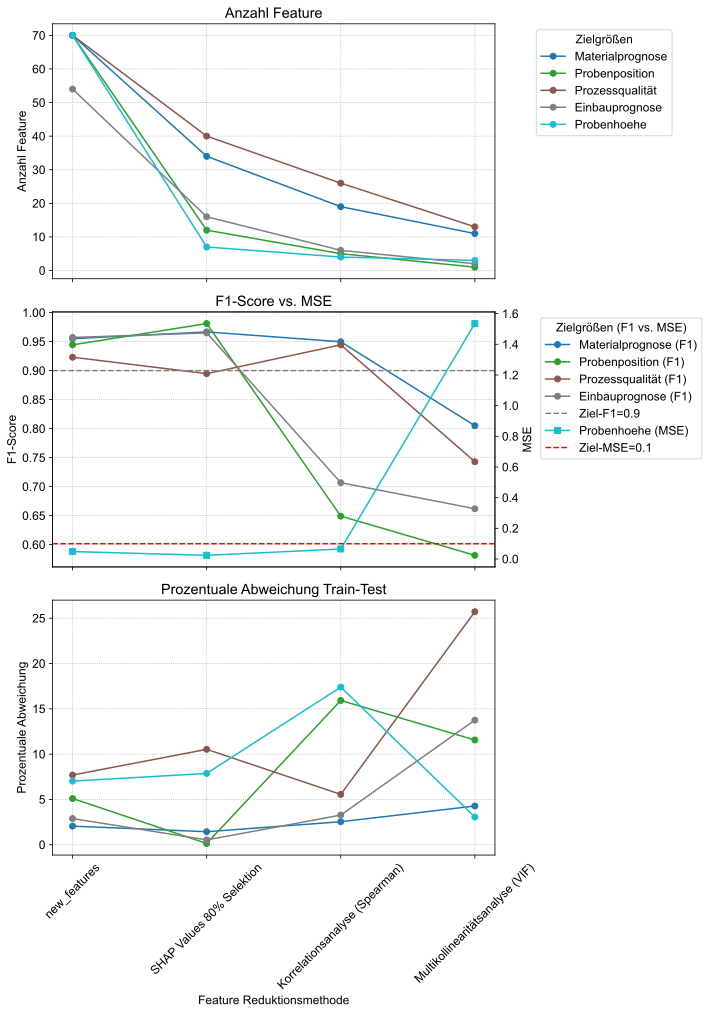

In [4]:
# Liste der CSV-Dateinamen (Passe den Pfad bei Bedarf an)
target_names = ["Materialprognose", "Probenposition", "Prozessqualität", "Einbauprognose", "Probenhoehe"]
filenames = []
for target in target_names:
    filenames.append(f"../results/best_models/{target}/summary_feature_selection_{target}.csv")

# Dictionary zum Speichern der DataFrames, Schlüssel: Zielgröße (aus dem Dateinamen)
data = {}

for file in filenames:
    # Extrahiere die Zielgröße aus dem Dateinamen
    target = file.split("_")[-1].split(".")[0]
    # Lese die CSV-Datei ein (Semikolon als Trenner)
    df = pd.read_csv(file, sep=";")
    # Setze die erste Spalte (Metrik-Namen) als Index
    df.set_index(df.columns[0], inplace=True)
    data[target] = df

# Angenommene Feature-Reduktionsmethoden (die Spaltennamen, z. B. ["Original", "SHAP 80%", ...])
methods = data[next(iter(data))].columns.tolist()

# Wir plotten 3 Subplots:
# 1) "Anzahl Feature"
# 2) F1 (alle Klassifikations-Zielgrößen) + MSE (Probenhoehe) auf einer Twin-Axis
# 3) "Prozentuale Abweichung Train-Test"

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 15), sharex=True)

# Farbpalette für die verschiedenen Zielgrößen
colors = plt.cm.get_cmap("tab10", len(data))

###############################################################################
# 1) Anzahl Feature
###############################################################################
ax0 = axs[0]
ax0.set_title("Anzahl Feature")
ax0.set_ylabel("Anzahl Feature")
ax0.grid(True, linestyle=":")

for j, (target, df) in enumerate(data.items()):
    # Stelle sicher, dass "Anzahl Feature" in df.index existiert
    if "Anzahl Feature" not in df.index:
        print(f"⚠️ 'Anzahl Feature' nicht in {target} gefunden.")
        continue
    # Extrahiere Werte als float
    values = df.loc["Anzahl Feature"].astype(float).values
    ax0.plot(methods, values, marker="o", label=target, color=colors(j))

###############################################################################
# 2) F1 vs. MSE (Twin Axis)
###############################################################################
ax1 = axs[1]
ax1.set_title("F1-Score vs. MSE")
ax1.grid(True, linestyle=":")

ax1_twin = ax1.twinx()
ax1.set_ylabel("F1-Score")
ax1_twin.set_ylabel("MSE")

# Speichere die Linien für spätere Legenden-Zusammenführung
lines_left = []
lines_right = []

for j, (target, df) in enumerate(data.items()):
    # F1-Wert in der CSV
    # MSE heißt z. B. "Test MSE" für Probenhoehe
    if target != "Probenhoehe":
        row_name = "F1-Score"
        label_text = f"{target} (F1)"
        if row_name not in df.index:
            print(f"⚠️ '{row_name}' nicht in {target} gefunden.")
            continue
        values = df.loc[row_name].astype(float).values
        line = ax1.plot(methods, values, marker="o", label=label_text, color=colors(j))
        lines_left.extend(line)
    else:
        # Zielgröße = Probenhoehe → MSE
        row_name = "Test MSE"  # Passe an, falls in deiner CSV anders
        label_text = f"{target} (MSE)"
        if row_name not in df.index:
            print(f"⚠️ '{row_name}' nicht in {target} gefunden.")
            continue
        values = df.loc[row_name].astype(float).values
        line = ax1_twin.plot(methods, values, marker="s", label=label_text, color=colors(j))
        lines_right.extend(line)

# Hier fügen wir die gestrichelten Linien für F1=0.9 und MSE=0.1 ein
line_f1 = ax1.axhline(y=0.9, color='gray', linestyle='--', label='Ziel-F1=0.9')
line_mse = ax1_twin.axhline(y=0.1, color='red', linestyle='--', label='Ziel-MSE=0.1')
lines_left.append(line_f1)
lines_right.append(line_mse)

###############################################################################
# 3) Prozentuale Abweichung Train-Test
###############################################################################
ax2 = axs[2]
ax2.set_title("Prozentuale Abweichung Train-Test")
ax2.set_ylabel("Prozentuale Abweichung")
ax2.grid(True, linestyle=":")

for j, (target, df) in enumerate(data.items()):
    row_name = "Prozentuale Abweichung Train-Test"
    if row_name not in df.index:
        print(f"⚠️ '{row_name}' nicht in {target} gefunden.")
        continue
    values = df.loc[row_name].astype(float).values
    ax2.plot(methods, values, marker="o", label=target, color=colors(j))

###############################################################################
# Gemeinsame X-Achse
###############################################################################
axs[-1].set_xlabel("Feature Reduktionsmethode")
axs[-1].set_xticks(np.arange(len(methods)))
axs[-1].set_xticklabels(methods, rotation=45)

# Gemeinsame Legende für Subplot 0 und 2 (einfach an subplot 0 hängen)
handles0, labels0 = ax0.get_legend_handles_labels()
axs[0].legend(handles0, labels0, title="Zielgrößen", bbox_to_anchor=(1.08, 1), loc="upper left")


# Legende zusammenführen
handles_left, labels_left = ax1.get_legend_handles_labels()
handles_right, labels_right = ax1_twin.get_legend_handles_labels()
axs[1].legend(handles_left + handles_right, labels_left + labels_right, 
              title="Zielgrößen (F1 vs. MSE)",
              bbox_to_anchor=(1.09, 1), loc="upper left")

plt.tight_layout()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("FeatureReduktion.svg", format="svg", dpi=310, bbox_inches="tight")
plt.show()

# Einfluss ohne Laserdistanzsensorik (Verkippungswerte)

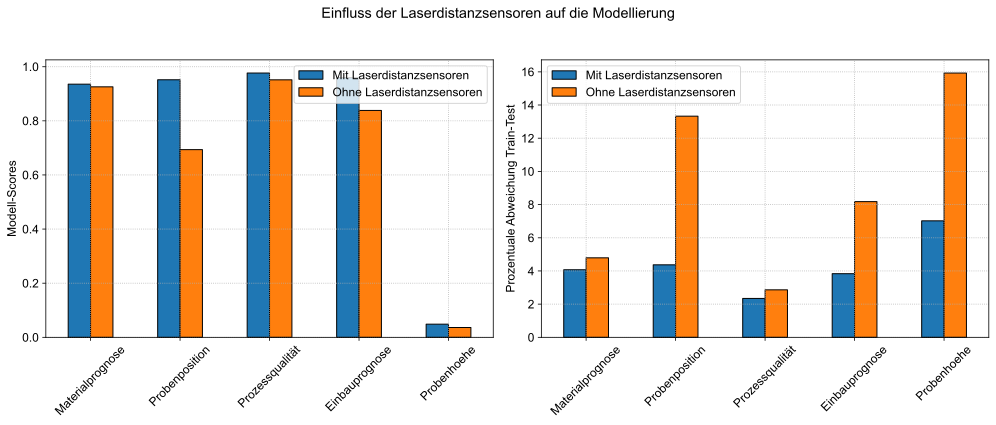

In [ ]:
def compare_sensor_effects(target_names, best_models, base_path):
    """
    Vergleicht den Einfluss des Sensors, indem für jeden Zielwert (z.B. Materialprognose,
    Probenposition, Prozessqualität, Einbauprognose, Probenhöhe) zwei CSV-Dateien eingelesen werden:
      - Eine mit Sensor (Dateiname: "{target}_model_scores_new_features{balance_suffix}.csv")
      - Eine ohne Sensor (Dateiname: "{target}_model_scores_new_features{balance_suffix}_no_tilt.csv")
      
    Für jedes Ziel wird das beste Modell (aus dem Dictionary best_models) ausgewählt und aus
    der entsprechenden Zeile der Metrik (bei Klassifikation: "f1_weighted", bei Probenhöhe: "Test MSE")
    sowie aus der Zeile der prozentualen Abweichung (entsprechend "percent_diff_f1_weighted" oder "percent_diff_MSE")
    der CSV extrahiert.
    
    Parameter:
      - target_names (list): Liste der Zielgrößen, z.B. ["Materialprognose", "Probenposition", "Prozessqualität", "Einbauprognose", "Probenhoehe"]
      - best_models (dict): Dictionary, das für jede Zielgröße den Namen des besten Modells enthält,
          z.B. {"Materialprognose": "SVM", "Probenposition": "Logistische Regression", "Prozessqualität": "kNN", "Einbauprognose": "Logistische Regression", "Probenhoehe": "XGBoost"}
      - base_path (str): Basisverzeichnis, in dem sich die CSV-Dateien befinden (z.B. "./compare/") --> muss manuell befüllt werden
      
    Returns:
      tuple: (df_scores, df_diff) – DataFrames mit den verglichenen Score-Werten und den prozentualen Abweichungen.
    """
    scores_with = {}
    diff_with = {}
    scores_without = {}
    diff_without = {}

    for target in target_names:
        # Für Prozessqualität wird "_noSMOTE" angehängt, ansonsten leer
        balance_suffix = "_noSMOTE" if target == "Prozessqualität" else ""
        
        file_with = os.path.join(base_path, f"{target}_model_scores_new_features{balance_suffix}.csv")
        file_without = os.path.join(base_path, f"{target}_model_scores_new_features{balance_suffix}_no_tilt.csv")
        
        try:
            df_with = pd.read_csv(file_with, sep=",")
            df_without = pd.read_csv(file_without, sep=",")
        except Exception as e:
            print(f"Fehler beim Laden der Dateien für {target}: {e}")
            continue
        
        # Setze die erste Spalte als Index und bereinige Index und Spaltennamen
        df_with.set_index(df_with.columns[0], inplace=True)
        df_without.set_index(df_without.columns[0], inplace=True)
        df_with.index = df_with.index.str.strip()
        df_with.columns = df_with.columns.str.strip()
        df_without.index = df_without.index.str.strip()
        df_without.columns = df_without.columns.str.strip()
        
        best_model = best_models.get(target)
        if best_model is None:
            print(f"Kein bestes Modell für {target} definiert.")
            continue
        # Entferne führende/nachgestellte Leerzeichen vom Modellnamen
        best_model = best_model.strip()
        
        # Überprüfe, ob die Spalte vorhanden ist
        if best_model not in df_with.columns:
            print(f"Spalte '{best_model}' nicht gefunden in der Datei mit Sensor für {target}. Verfügbare Spalten: {df_with.columns.tolist()}")
            continue
        if best_model not in df_without.columns:
            print(f"Spalte '{best_model}' nicht gefunden in der Datei ohne Sensor für {target}. Verfügbare Spalten: {df_without.columns.tolist()}")
            continue
        
        # Wähle die Metriken: Bei Probenhoehe (Regression) Test MSE und percent_diff_MSE, sonst f1_weighted und percent_diff_f1_weighted
        if target == "Probenhoehe":
            score_metric = "Test MSE"
            diff_metric = "percent_diff_MSE"
        else:
            score_metric = "f1_weighted"
            diff_metric = "percent_diff_f1_weighted"
        
        try:
            score_with = pd.to_numeric(df_with.loc[score_metric, best_model], errors="coerce")
            diff_with_val = pd.to_numeric(df_with.loc[diff_metric, best_model], errors="coerce")
        except Exception as e:
            print(f"Fehler bei 'mit Sensor' für {target}: {e}")
            score_with, diff_with_val = np.nan, np.nan
        
        try:
            score_without = pd.to_numeric(df_without.loc[score_metric, best_model], errors="coerce")
            diff_without_val = pd.to_numeric(df_without.loc[diff_metric, best_model], errors="coerce")
        except Exception as e:
            print(f"Fehler bei 'ohne Sensor' für {target}: {e}")
            score_without, diff_without_val = np.nan, np.nan
        
        scores_with[target] = score_with
        diff_with[target] = diff_with_val
        scores_without[target] = score_without
        diff_without[target] = diff_without_val

    df_scores = pd.DataFrame({
        "Mit Laserdistanzsensoren": pd.Series(scores_with),
        "Ohne Laserdistanzsensoren": pd.Series(scores_without)
    })
    df_diff = pd.DataFrame({
        "Mit Laserdistanzsensoren": pd.Series(diff_with),
        "Ohne Laserdistanzsensoren": pd.Series(diff_without)
    })
    
    # Visualisierung
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    df_scores.plot(kind="bar", ax=axs[0], rot=45, edgecolor="black")
    axs[0].set_ylabel("Modell-Scores")
    #axs[0].set_title("Modell-Scores")
    axs[0].grid(True, linestyle=":")
    
    df_diff.plot(kind="bar", ax=axs[1], rot=45, edgecolor="black")
    axs[1].set_ylabel("Prozentuale Abweichung Train-Test")
    #axs[1].set_title("Prozentuale Abweichung Train-Test")
    axs[1].grid(True, linestyle=":")
    
    plt.suptitle("Einfluss der Laserdistanzsensoren auf die Modellierung")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig("vergleichBauteiltemp.svg", format="svg", dpi=300, bbox_inches="tight")
    plt.show()
    
    return df_scores, df_diff

# Beispielaufruf:
target_names = ["Materialprognose", "Probenposition", "Prozessqualität", "Einbauprognose", "Probenhoehe"]
best_models = {
    "Materialprognose": "SVM",
    "Probenposition": "Logistische Regression",
    "Prozessqualität": "kNN",
    "Einbauprognose": "Logistische Regression",
    "Probenhoehe": "XGBoost"
}
base_path = "./compare/" # Hier müssen die Scores abgelegt werden
df_scores, df_diff = compare_sensor_effects(target_names, best_models, base_path)


## Gleiches Diagramm nur nicht nebeneinander

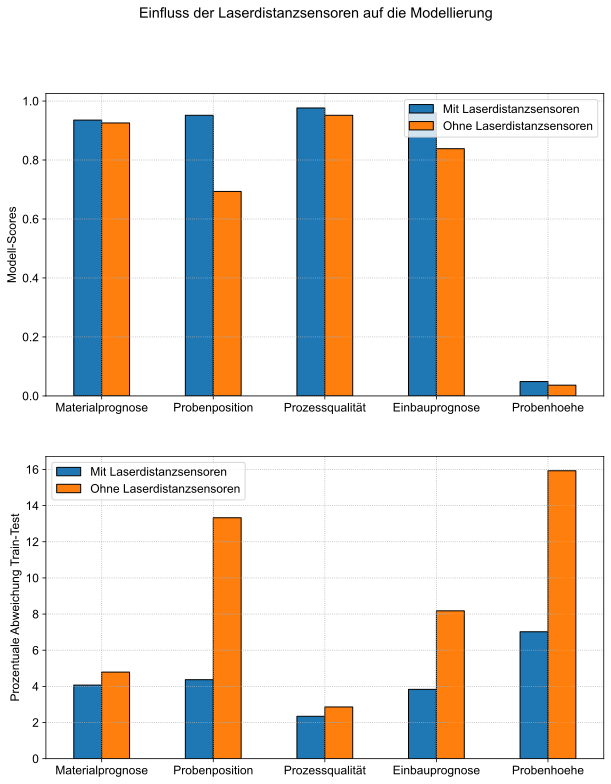

In [11]:
import textwrap
import matplotlib.pyplot as plt

def custom_wrap_labels(ax, max_line_length=12):
    """Ersetzt ' (' durch '\\n(', dann bricht zu lange Zeilen."""
    new_labels = []
    for label_obj in ax.get_xticklabels():
        text = label_obj.get_text()
        # 1) Sorgt dafür, dass bei Klammern ein Zeilenumbruch erzwungen wird
        text = text.replace(" (", "\n(")
        # 2) Zeilen bei max_line_length Zeichen umbrechen
        lines = textwrap.wrap(text, width=max_line_length)
        # Zusammenfügen mit '\n'
        new_text = "\n".join(lines)
        new_labels.append(new_text)

    # xticklabels aktualisieren, Rotation = 0, zentriert
    ax.set_xticklabels(new_labels, rotation=0, ha="center")

# Beispielcode für manuelle Zeilenumbrüche

fig, axs = plt.subplots(2, 1, figsize=(10, 12))  # 2 rows, 1 column for subplots

df_scores.plot(kind="bar", ax=axs[0], edgecolor="black")
axs[0].set_ylabel("Modell-Scores")
axs[0].grid(True, linestyle=":")

df_diff.plot(kind="bar", ax=axs[1], edgecolor="black")
axs[1].set_ylabel("Prozentuale Abweichung Train-Test")
axs[1].grid(True, linestyle=":")

plt.suptitle("Einfluss der Laserdistanzsensoren auf die Modellierung")

# Manuelle Zeilenumbrüche definieren
def manual_line_breaks(ax):
    new_labels = []
    for lbl in ax.get_xticklabels():
        txt = lbl.get_text()

        # Beispielhafte Ersetzungen:
        # 1) "Probenposition (Logistische Regression)" --> "Probenposition\n(Logistische Regression)"
        # 2) "Einbauprognose (Logistische Regression)"  --> "Einbauprognose\n(Logistische Regression)"
        # 3) "Probenhoehe (XGBoost)" --> "Probenhoehe\n(XGBoost)"
        # Du kannst hier beliebige Ersetzungen einfügen:
        txt = txt.replace("(Logistische Regression)", "\n(Logistische\nRegression)")
        txt = txt.replace("(kNN)", "\n(kNN)")
        txt = txt.replace("(XGBoost)", "\n(XGBoost)")
        txt = txt.replace("(SVM)", "\n(SVM)")

        # Falls du noch weitere Umbrüche möchtest, kannst du sie hier definieren
        # z.B.: txt = txt.replace("Prozessqualität", "Prozess\nqualität")

        new_labels.append(txt)

    # Setze die manipulierten Texte als xticklabels (ohne Rotation)
    ax.set_xticklabels(new_labels, rotation=0, ha="center")

for ax in axs:
    manual_line_breaks(ax)

# Einfluss ohne Bauteiltemperatur

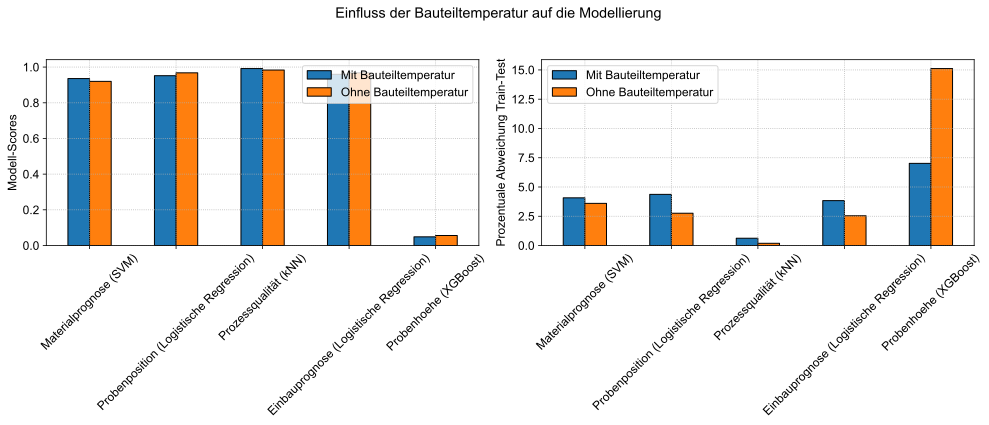

In [5]:
def compare_temp_effects(target_names, best_models, base_path):
    """
    Vergleicht den Einfluss der Bauteiltemperatur, indem für jeden Zielwert
    zwei CSV-Dateien eingelesen werden:
      - Eine mit Bauteiltemperatur (Dateipfad: "{target}/new_features/model_scores_new_features{balance_suffix}.csv")
      - Eine ohne Bauteiltemperatur (Dateipfad: "{target}/new_features_noTemp/model_scores_new_features{balance_suffix}.csv")
      
    Für jedes Target wird aus dem DataFrame (bzw. der entsprechenden Zeile) des besten Modells
    der Score (bei Klassifikation: "f1_weighted", bei Probenhöhe: "Test MSE") sowie die
    prozentuale Abweichung (z. B. "percent_diff_f1_weighted" bzw. "percent_diff_MSE") extrahiert.
    
    Parameter:
      - target_names (list): Liste der Zielgrößen, z. B. ["Materialprognose", "Probenposition", "Prozessqualität", "Einbauprognose", "Probenhoehe"]
      - best_models (dict): Dictionary, das für jedes Target den Namen des besten Modells enthält,
          z. B. {"Materialprognose": "SVM", "Probenposition": "Logistische Regression", ...}
      - base_path (str): Basisverzeichnis, in dem sich die CSV-Dateien befinden (z. B. "./results/")
      
    Returns:
      tuple: (df_scores, df_diff) – DataFrames mit den verglichenen Score-Werten und den prozentualen Abweichungen.
    """
    scores_with = {}
    diff_with = {}
    scores_without = {}
    diff_without = {}

    for target in target_names:
        # Balance Suffix: Bei Prozessqualität wird "_noSMOTE" angehängt, ansonsten leer
        balance_suffix = "noSMOTE" if target == "Prozessqualität" else ""
        
        # Erstelle die Pfade zu den CSV-Dateien unter Berücksichtigung des Balance Suffix
        file_with = os.path.join(base_path, f"{target}/{balance_suffix}/new_features/model_scores_new_features{balance_suffix}.csv")
        file_without = os.path.join(base_path, f"{target}/{balance_suffix}noTemp/new_features/model_scores_new_features{balance_suffix}.csv")
        
        try:
            df_with = pd.read_csv(file_with, sep=",")
            df_without = pd.read_csv(file_without, sep=",")
        except Exception as e:
            print(f"Fehler beim Laden der Dateien für {target}: {e}")
            continue
        
        # Setze die erste Spalte als Index und bereinige Index und Spaltennamen
        df_with.set_index(df_with.columns[0], inplace=True)
        df_without.set_index(df_without.columns[0], inplace=True)
        df_with.index = df_with.index.str.strip()
        df_with.columns = df_with.columns.str.strip()
        df_without.index = df_without.index.str.strip()
        df_without.columns = df_without.columns.str.strip()
        
        best_model = best_models.get(target)
        if best_model is None:
            print(f"Kein bestes Modell für {target} definiert.")
            continue
        best_model = best_model.strip()
        
        if best_model not in df_with.columns:
            print(f"Spalte '{best_model}' nicht gefunden in der Datei mit Bauteiltemperatur für {target}. Verfügbare Spalten: {df_with.columns.tolist()}")
            continue
        if best_model not in df_without.columns:
            print(f"Spalte '{best_model}' nicht gefunden in der Datei ohne Bauteiltemperatur für {target}. Verfügbare Spalten: {df_without.columns.tolist()}")
            continue
        
        # Wähle die Metriken: Bei Probenhoehe (Regression) Test MSE und percent_diff_MSE, sonst f1_weighted und percent_diff_f1_weighted
        if target == "Probenhoehe":
            score_metric = "Test MSE"
            diff_metric = "percent_diff_MSE"
        else:
            score_metric = "f1_weighted"
            diff_metric = "percent_diff_f1_weighted"
        
        try:
            score_with = pd.to_numeric(df_with.loc[score_metric, best_model], errors="coerce")
            diff_with_val = pd.to_numeric(df_with.loc[diff_metric, best_model], errors="coerce")
        except Exception as e:
            print(f"Fehler bei 'mit Bauteiltemperatur' für {target}: {e}")
            score_with, diff_with_val = np.nan, np.nan
        
        try:
            score_without = pd.to_numeric(df_without.loc[score_metric, best_model], errors="coerce")
            diff_without_val = pd.to_numeric(df_without.loc[diff_metric, best_model], errors="coerce")
        except Exception as e:
            print(f"Fehler bei 'ohne Bauteiltemperatur' für {target}: {e}")
            score_without, diff_without_val = np.nan, np.nan
        
        scores_with[target] = score_with
        diff_with[target] = diff_with_val
        scores_without[target] = score_without
        diff_without[target] = diff_without_val

    df_scores = pd.DataFrame({
        "Mit Bauteiltemperatur": pd.Series(scores_with),
        "Ohne Bauteiltemperatur": pd.Series(scores_without)
    })
    df_diff = pd.DataFrame({
        "Mit Bauteiltemperatur": pd.Series(diff_with),
        "Ohne Bauteiltemperatur": pd.Series(diff_without)
    })
    
    # Index (Zeilenbeschriftung) anpassen: Füge den jeweiligen Modellnamen in Klammern hinzu
    new_index = [f"{target} ({best_models.get(target, 'nicht definiert')})" for target in df_scores.index]
    df_scores.index = new_index
    df_diff.index = new_index

    # Visualisierung
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    df_scores.plot(kind="bar", ax=axs[0], rot=45, edgecolor="black")
    axs[0].set_ylabel("Modell-Scores")
    axs[0].grid(True, linestyle=":")
    
    df_diff.plot(kind="bar", ax=axs[1], rot=45, edgecolor="black")
    axs[1].set_ylabel("Prozentuale Abweichung Train-Test")
    axs[1].grid(True, linestyle=":")
    
    plt.suptitle("Einfluss der Bauteiltemperatur auf die Modellierung")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig("vergleichBauteiltemp.svg", format="svg", dpi=300, bbox_inches="tight")
    plt.show()
    
    return df_scores, df_diff

# Beispielaufruf:
target_names = ["Materialprognose", "Probenposition", "Prozessqualität", "Einbauprognose", "Probenhoehe"]
best_models = {
    "Materialprognose": "SVM",
    "Probenposition": "Logistische Regression",
    "Prozessqualität": "kNN",
    "Einbauprognose": "Logistische Regression",
    "Probenhoehe": "XGBoost"
}
base_path = "../results/"
df_scores, df_diff = compare_temp_effects(target_names, best_models, base_path)

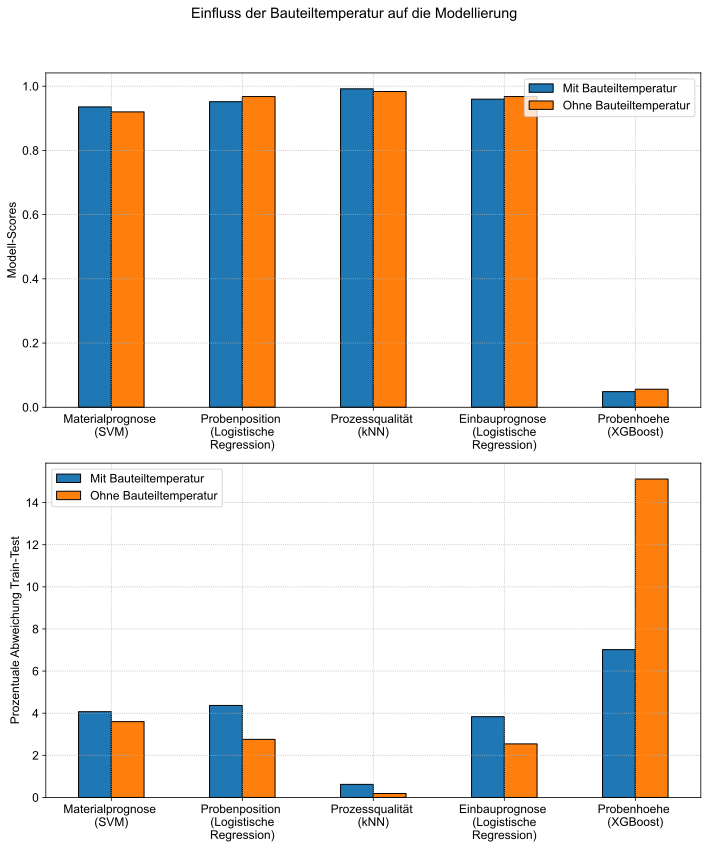

In [ ]:
import textwrap
import matplotlib.pyplot as plt

def custom_wrap_labels(ax, max_line_length=12):
    """Ersetzt ' (' durch '\\n(', dann bricht zu lange Zeilen."""
    new_labels = []
    for label_obj in ax.get_xticklabels():
        text = label_obj.get_text()
        # 1) Sorgt dafür, dass bei Klammern ein Zeilenumbruch erzwungen wird
        text = text.replace(" (", "\n(")
        # 2) Zeilen bei max_line_length Zeichen umbrechen
        lines = textwrap.wrap(text, width=max_line_length)
        # Zusammenfügen mit '\n'
        new_text = "\n".join(lines)
        new_labels.append(new_text)

    # xticklabels aktualisieren, Rotation = 0, zentriert
    ax.set_xticklabels(new_labels, rotation=0, ha="center")


fig, axs = plt.subplots(2, 1, figsize=(10, 12))  # 2 rows, 1 column for subplots

df_scores.plot(kind="bar", ax=axs[0], edgecolor="black")
axs[0].set_ylabel("Modell-Scores")
axs[0].grid(True, linestyle=":")

df_diff.plot(kind="bar", ax=axs[1], edgecolor="black")
axs[1].set_ylabel("Prozentuale Abweichung Train-Test")
axs[1].grid(True, linestyle=":")

plt.suptitle("Einfluss der Bauteiltemperatur auf die Modellierung")

# Manuelle Zeilenumbrüche definieren
def manual_line_breaks(ax):
    new_labels = []
    for lbl in ax.get_xticklabels():
        txt = lbl.get_text()

        # Beispielhafte Ersetzungen:
        # 1) "Probenposition (Logistische Regression)" --> "Probenposition\n(Logistische Regression)"
        # 2) "Einbauprognose (Logistische Regression)"  --> "Einbauprognose\n(Logistische Regression)"
        # 3) "Probenhoehe (XGBoost)" --> "Probenhoehe\n(XGBoost)"
        # Du kannst hier beliebige Ersetzungen einfügen:
        txt = txt.replace("(Logistische Regression)", "\n(Logistische\nRegression)")
        txt = txt.replace("(kNN)", "\n(kNN)")
        txt = txt.replace("(XGBoost)", "\n(XGBoost)")
        txt = txt.replace("(SVM)", "\n(SVM)")

        # Falls du noch weitere Umbrüche möchtest, kannst du sie hier definieren
        # z.B.: txt = txt.replace("Prozessqualität", "Prozess\nqualität")

        new_labels.append(txt)

    # Setze die manipulierten Texte als xticklabels (ohne Rotation)
    ax.set_xticklabels(new_labels, rotation=0, ha="center")

for ax in axs:
    manual_line_breaks(ax)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("vergleichBauteiltemp.svg", format="svg", dpi=300, bbox_inches="tight")
plt.show()
plt.show()